# TP de Video Processing

## Importation des modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import calendar
import time
import cv2
import numpy as np
from matplotlib.patches import Polygon
OUTPUT_DIRECTORY = './outputs'

## **Question A**
Partant de deux frames F1 et F2 où F2 succède à F1 dans le temps, estimez par une méthode pixel-wise les vecteurs de mouvements des pixels de la frame F1 vers F2 (en admettant l’hypothèse de l’intensité constante).

## Chargement des frames

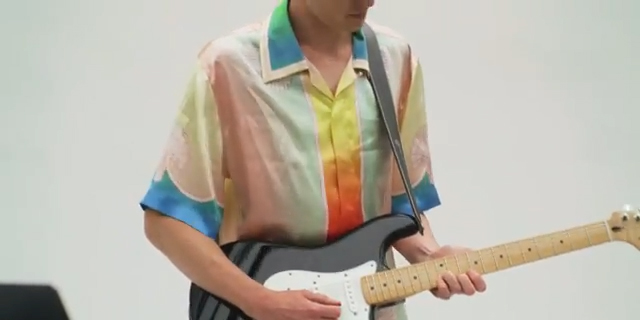

In [208]:
img1 = Image.open("images/LF016.jpg")
img2 = Image.open("images/LF017.jpg")
img1

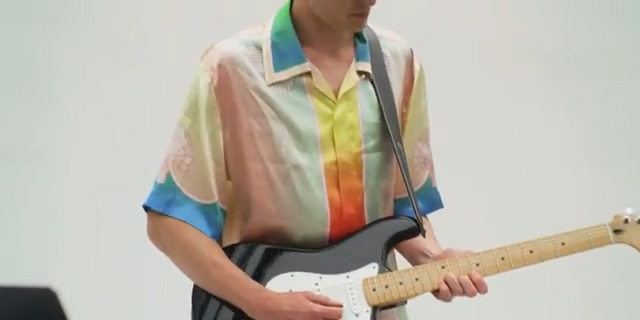

In [209]:
img2

## Création des nd arrays associés aux images

In [210]:
frame_array_1 = np.asarray(img1)
frame_array_2 = np.asarray(img2)
# Vérification 
assert frame_array_1.shape == frame_array_2.shape

## Fonction qui mesure l'écart entre 2 pixels

Il s'agit ici d'appliquuer la distance de Manhattan (ou $\lVert.\lVert_1$) entre deux vecteurs qui sont dans ce cas des pixels en RGB.

In [211]:
def get_absolute_diff_sum(pixel_a, pixel_b):
    return (abs((pixel_a).astype(int) - (pixel_b).astype(int))).sum()

## Déterminer les vecteurs de mouvement

### Déterminer le vecteur au niveau d'un pixel

La fonction ci-dessous va prendre un pixel aux coordonnées `x,y` de la `frame_1` et va chercher dans un voisinage de taille `max_distance` (autour de `(x,y)` )  un pixel de la `frame_2` un pixel ayant une luminescence (une valeur RGB) la plus proche.

In [212]:
def get_closer_pixel(frame_array_1,frame_array_2,x,y, max_distance):
    
    best_pixel_coord = None
    best_pixel = None
    pixel_to_find = frame_array_1[x][y]
    # On cherche d'abord les pixels les plus éloignées en partant d'une distance de `max_distance`
    for current_distance in range(max_distance,-1,-1):
        # On fixe les limites d'abscisse et d'ordonnée du tableau
        x_left_bound = max(0,x-current_distance)
        x_right_bound = min(frame_array_1.shape[0],x+current_distance+1)
        y_bottom_bound,y_top_bound =max(0,y-current_distance),min(frame_array_1.shape[1],y+current_distance+1)
        for x_neigbour in range(x_left_bound,x_right_bound):
            for y_neigbour in range(y_bottom_bound,y_top_bound):
                
                if((abs(x_neigbour-x) + abs(y_neigbour-y)) == current_distance):
                    neigbour_pixel = frame_array_2[x_neigbour][y_neigbour]
                    pixel_diff_sum = get_absolute_diff_sum(neigbour_pixel, pixel_to_find)
                    need_to_change = (best_pixel_coord is None)
                    # On vérifie s'il y a une meilleure proximité en comparaison du pixel précédent
                    need_to_change = need_to_change or (pixel_diff_sum <= get_absolute_diff_sum(best_pixel, pixel_to_find))
                    if(need_to_change):
                        # On met à jour les coordonnées dans le cas ou un pixel de la frame_2 est meilleur candidat que le précédent.
                        best_pixel_coord = x_neigbour,y_neigbour
                        best_pixel = neigbour_pixel
        
    return best_pixel_coord
    

Après avoir déterminer le pixel de la frame 2 le plus proche de celui de la frame 1 on renvoie un tuple qui correspond à un vecteur de mouvement.

In [213]:
def get_move_vector(frame_array_1,frame_array_2,x,y,step):
    new_x, new_y = get_closer_pixel(frame_array_1,frame_array_2,x,y,step)
    return new_x-x, new_y-y

### Déterminer les vecteurs de mouvement au niveau de tous les pixels de la frame

Le but va être de générer deux ndarrays u et v. Ces deux arrays correspondent respectivement aux coordonées directionnelles de chaque point de la frame.
u va représenter les abcisses de chaque point et v les ordonnées. 

In [214]:
def generate_move_vectors(frame_array_1,frame_array_2,step):
    count =0
    u = np.ndarray(shape=frame_array_1.shape[0:2])
    u.fill(0.)
    v = np.ndarray(shape=frame_array_1.shape[0:2])
    v.fill(0.)
    total_count = frame_array_1.shape[0]*frame_array_1.shape[1]
    first = time.time()
    for x in range(frame_array_1.shape[0]):
        for y in range(frame_array_1.shape[1]):
            if(count == total_count//100):
                second = time.time()
                estimated_time = (second -first)*100
                print(f'{int(estimated_time)//60} minutes and {int(estimated_time)%60} seconds left ')
            vector= get_move_vector(frame_array_1,frame_array_2,x,y,step)
            u[x][y]= vector[0]
            v[x][y]= vector[1]
            count+=1
    return u,v


## Afficher les vecteurs de mouvement

Ensuite nous générons les meshgrids ainsi que les vecteurs de mouvement u et v.

In [215]:
STEP = 5
window_size = 5
def compute_movement_vectors(frame_array_1,frame_array_2):
    u,v = generate_move_vectors(frame_array_1,frame_array_2,STEP)
    u =  u[::window_size,::window_size]
    v = v[::window_size,::window_size]
    x =  np.arange(frame_array_1.shape[1])  
    y = np.arange(frame_array_1.shape[0]-1,-1,-1) 
    X, Y = np.meshgrid(x[::window_size], y[::window_size])
    return X,Y, u, v

X,Y, u, v = compute_movement_vectors(frame_array_1,frame_array_2)

2 minutes and 25 seconds left 


Il faut maintenant afficher via Quiver l'ensemble des vecteurs de mouvements

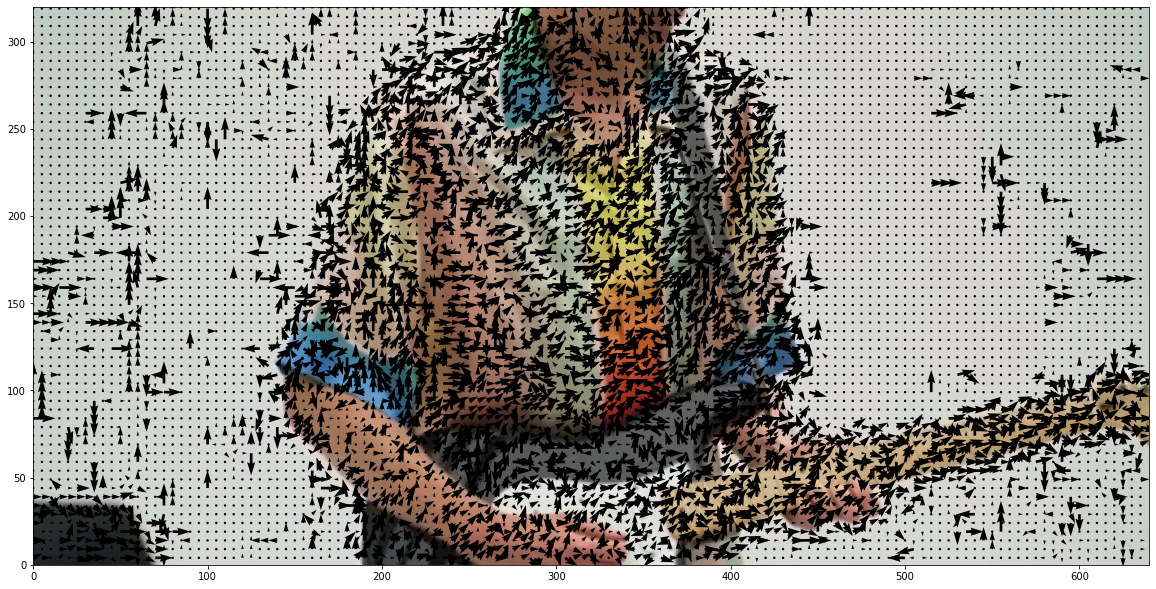

In [216]:
def display_movement_vectors( X,Y, u, v):
    fig, ax = plt.subplots(figsize =(20, 20))
    ax.quiver(X, Y, u, v,scale=250)
    ax.axis([0, frame_array_1.shape[1], 0,frame_array_1.shape[0] ])
    ax.set_aspect('equal')
    plt.imshow(np.flip(frame_array_1,(0)))
    plt.show()
    fig.savefig(f'{OUTPUT_DIRECTORY}/pixel-wise.png')

display_movement_vectors(X,Y, u, v)

## **Question B**
Refaire cette même estimation par blocs (BMA) pour différentes tailles de blocs.

Ici nous allons appliquer de deux manières le (BMA), premièrement avec une méthode itérative et ensuite avec une méthode proposée par la librairie cv2 pour comparer nos observations.

Dans le but d'avoir un code épuré et compréhensible un ensemble de classe va être créé.

In [138]:
class BlockWiseComputer:
    block_size = 10
    window_size = 10
    def set_block_size(self,block_size :int) -> None:
        self.block_size = block_size
    def set_window_size(self,window_size :int) -> None:
        self.window_size = window_size

C'est dans cette sous-classe qu'est implémenté l'algorithme BMA en se référant à la formule de l'erreur $E(d_m,\forall m \in \mathcal{M})=\sum_{m\in \mathcal{M}}\sum_{x\in B_m}|\psi_2(x+d_m) - \psi_1(x)|^p$

In [217]:

class FromScratchBlockWiseComputer(BlockWiseComputer):
    def __init__(self, frame_1_file_name :str, frame_2_file_name :str ) -> None:
        img1 = Image.open(frame_1_file_name)
        img2 = Image.open(frame_2_file_name)
        self.frame_array_1 = np.asarray(img1)
        self.frame_array_2 = np.asarray(img2)
    
    def get_min_error_block(self,x :int,y:int) -> tuple:
        height, width = self.frame_array_1.shape[:2]
        left_x_bound = max(x-self.window_size,0)
        right_x_bound = min(x+self.window_size,height-self.block_size)
        left_y_bound = max(y-self.window_size,0)
        right_y_bound = min(y+self.window_size,width-self.block_size)
        block_1 = self.frame_array_1[x:x+self.block_size,y:y+self.block_size].astype(int)
        min_cost = float('inf')
        best_match = (0,0)
        for i in range(left_x_bound,right_x_bound):
            for j in range(left_y_bound,right_y_bound):
                block_2 = self.frame_array_2[i:i+self.block_size,j:j+self.block_size].astype(int)
                assert(block_1.shape == block_2.shape  or print(x,y,block_1.shape,block_2.shape,i,j,left_y_bound,right_y_bound))
                cost = np.mean(np.abs(block_1 - block_2))
                if(cost < min_cost):
                    min_cost =cost
                    best_match = (x,y,x-i,y-j)
    
        return best_match
    
    def from_scratch_block_wise(self) -> np.ndarray :
        height, width = self.frame_array_1.shape[:2]
        flow_vectors = []
        for x in range(0,height-self.block_size+1,self.block_size):
            for y in range(0,width-self.block_size+1,self.block_size):
                best_match = self.get_min_error_block(x,y)
                flow_vectors.append(best_match)
                
        img_to_display = np.copy(self.frame_array_1)
        for point in flow_vectors:
            x,y,dx,dy = point
            cv2.arrowedLine( img_to_display,(y,x), (int(dy+y),int(dx+x)), (0, 0, 0),1)
        
        print(f'Motion estimation by block wise method with {self.block_size} for block size and {self.window_size} for window size.')
        return img_to_display
    
    def __call__(self,block_size:int = BlockWiseComputer.block_size) -> None:
        self.block_size = block_size
        return self.from_scratch_block_wise()
        

Appliquons maintenant une série d'estimation de mouvement avec différentes tailles de blocs.

Motion estimation by block wise method with 5 for block size and 10 for window size.


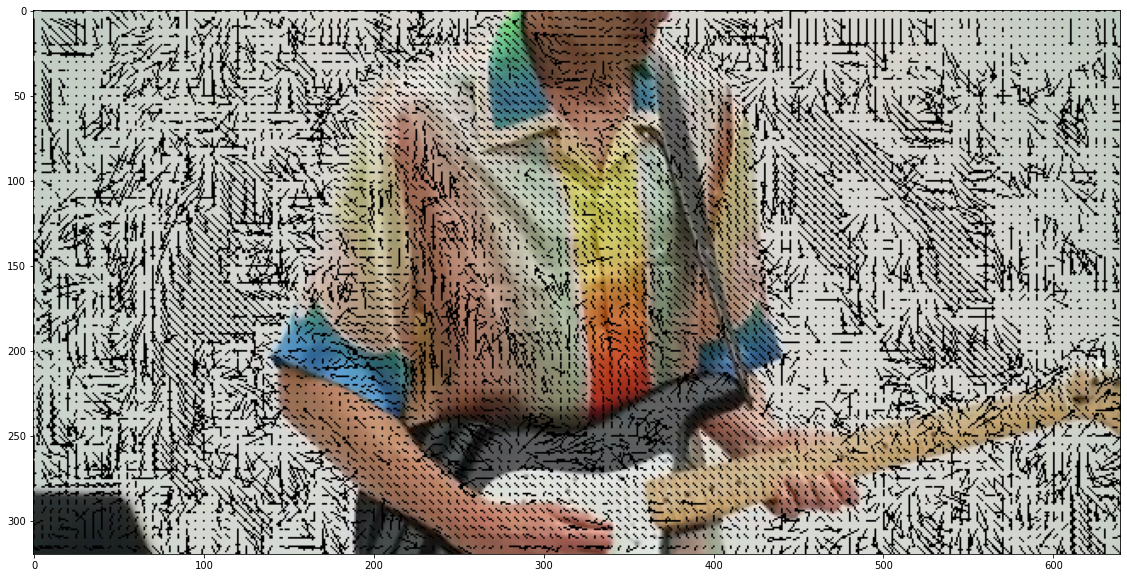

Motion estimation by block wise method with 10 for block size and 10 for window size.


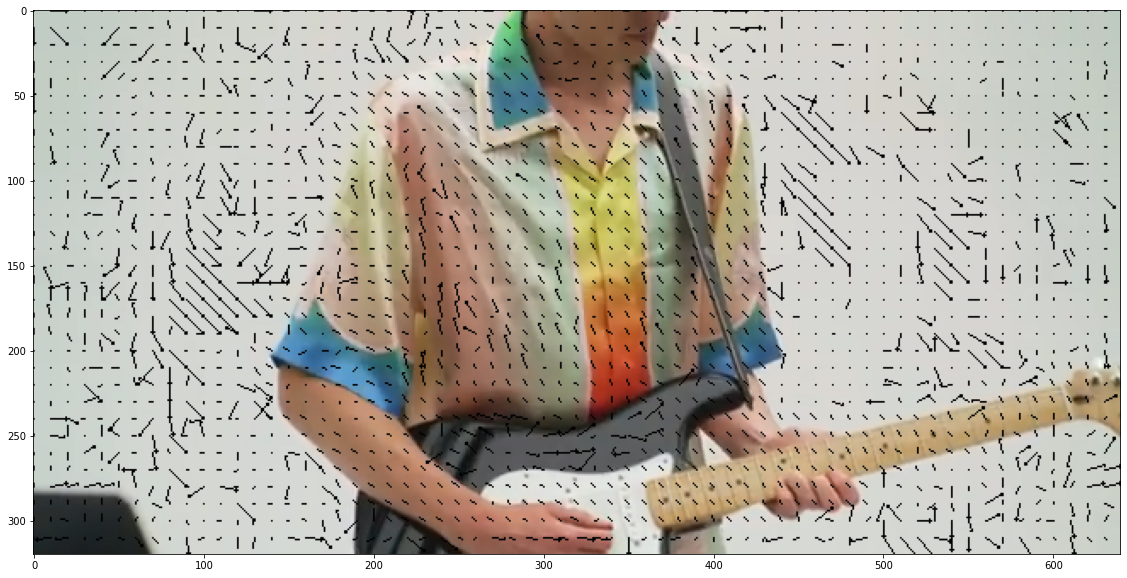

Motion estimation by block wise method with 15 for block size and 10 for window size.


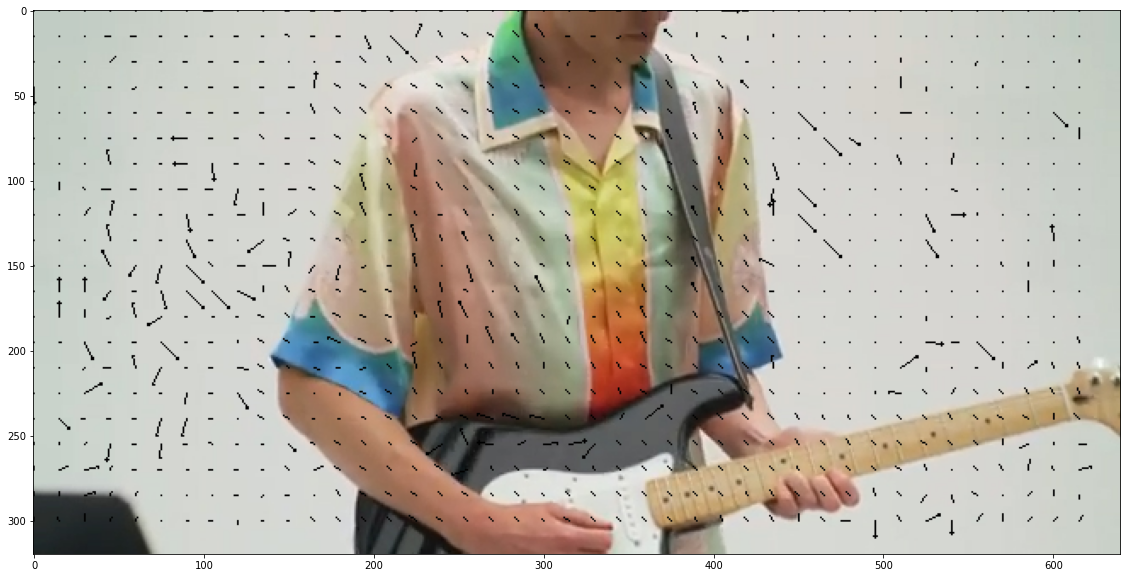

Motion estimation by block wise method with 20 for block size and 10 for window size.


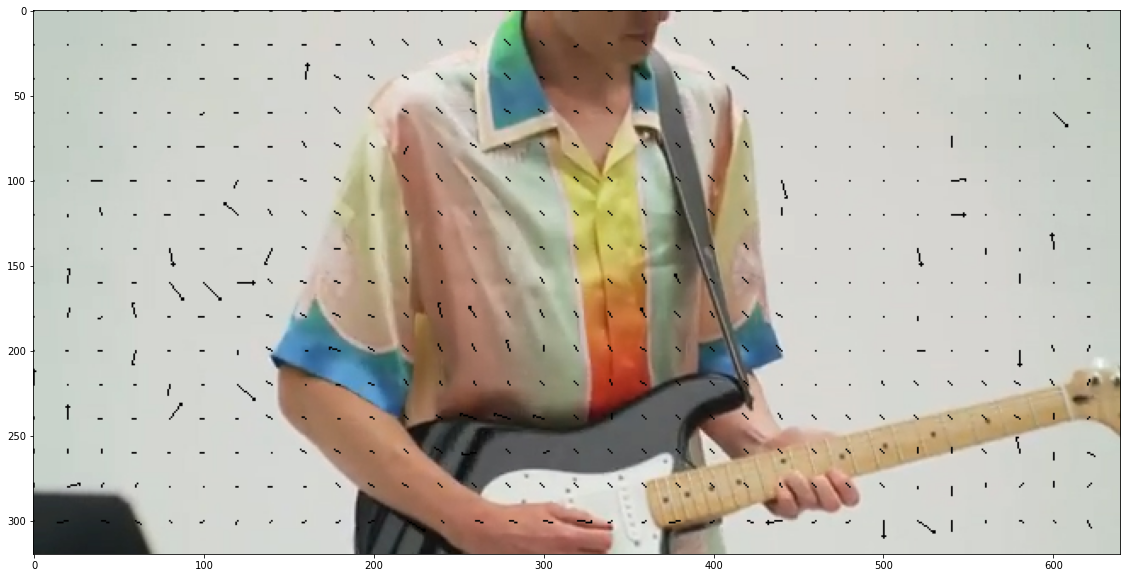

Motion estimation by block wise method with 25 for block size and 10 for window size.


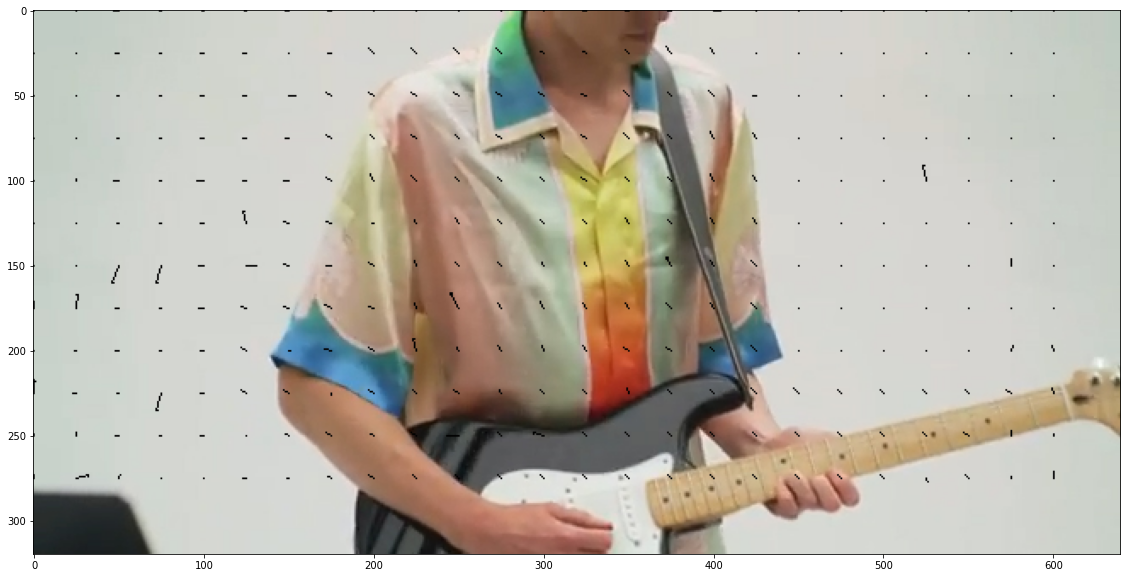

In [218]:
blockwisecomputer = FromScratchBlockWiseComputer("images/LF016.jpg","images/LF017.jpg")

for size in range(5,30,5):
    fig, ax = plt.subplots(figsize =(20, 10))
    img_to_display = blockwisecomputer(size)
    plt.imshow(img_to_display)
    plt.show()
    fig.savefig(f'{OUTPUT_DIRECTORY}/block-wise-with{size}.png')
    

### Commentaires

Motion estimation by block wise method with 5 for block size and 10 for window size.


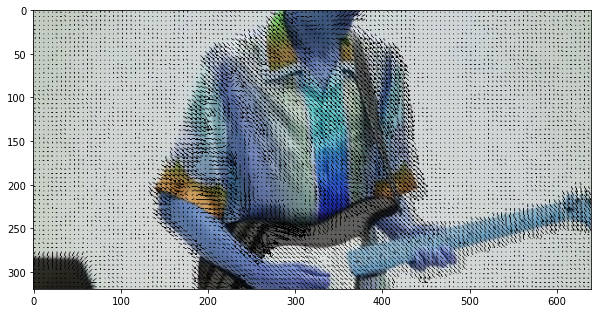

Motion estimation by block wise method with 10 for block size and 10 for window size.


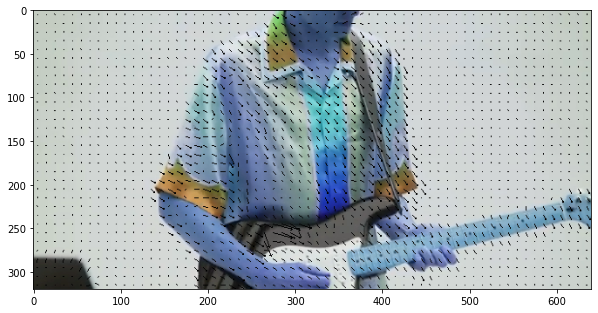

Motion estimation by block wise method with 15 for block size and 10 for window size.


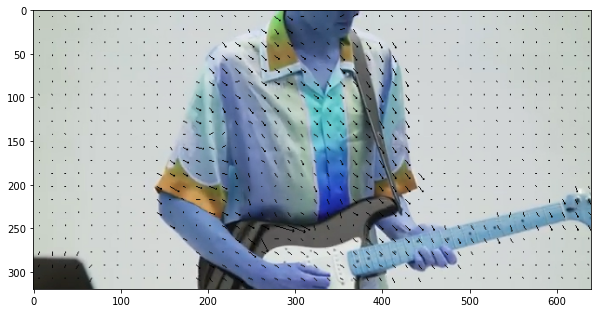

Motion estimation by block wise method with 20 for block size and 10 for window size.


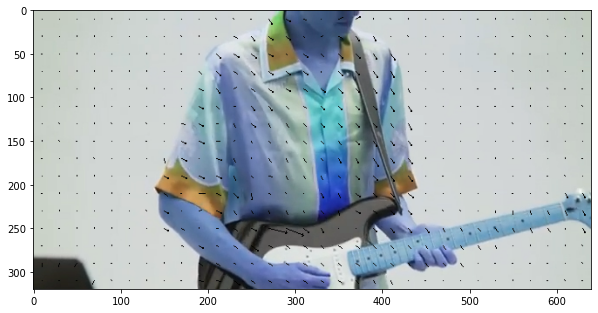

Motion estimation by block wise method with 25 for block size and 10 for window size.


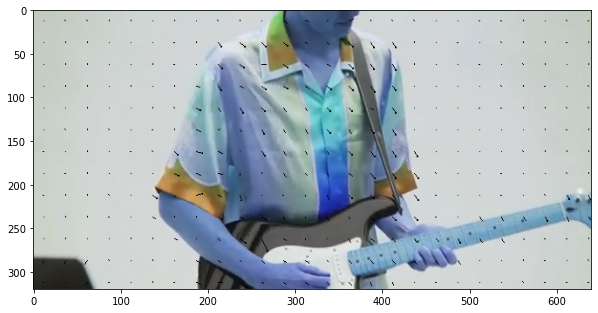

In [219]:

class CV2BlockWiseComputer(BlockWiseComputer):
    def __init__(self, frame_1_file_name :str, frame_2_file_name :str ) -> None:
        self.frame_array_1 = cv2.imread(frame_1_file_name)
        self.frame_array_2 = cv2.imread(frame_2_file_name)
        return
    
    def __call__(self,block_size:int = -1) -> None:
        if(block_size != -1):
            self.block_size = block_size
        # convertir les images en niveau de gris
        gray1 = cv2.cvtColor(self.frame_array_1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(self.frame_array_2, cv2.COLOR_BGR2GRAY)
        shift_size = self.block_size

        # calculer le flux optique avec la méthode block-wise
        flow = cv2.calcOpticalFlowFarneback(gray1, gray2, flow=None, pyr_scale =0.5, levels=self.block_size, winsize=self.window_size, iterations=5, poly_n=16, poly_sigma=1.2, flags=0)

        ## créer une grille de points pour dessiner les vecteurs de flux
        h, w = gray1.shape
        grid_y, grid_x = np.mgrid[shift_size//2:h:shift_size, shift_size//2:w:shift_size].reshape(2, -1).astype(int)
        points = np.vstack([grid_x, grid_y]).T
        
        ## dessiner les vecteurs de flux sur une copie de l'image 1
        img_to_display = np.copy(self.frame_array_1)
        for x, y in points:
            dx, dy = flow[y, x]
            dx*=2
            dy*=2
            cv2.arrowedLine(img_to_display, (x, y), (int(x+dx), int(y+dy)), (0, 0, 0))
    
        print(f'Motion estimation by block wise method with {self.block_size} for block size and {self.window_size} for window size.')
        return img_to_display
        
cv2_blockwisecomputer = CV2BlockWiseComputer("images/LF016.jpg","images/LF017.jpg")
for size in range(5,30,5):
    fig, ax = plt.subplots(figsize =(10, 6))
    img_to_display = cv2_blockwisecomputer(size)
    plt.imshow(img_to_display)
    plt.show()
    fig.savefig(f'{OUTPUT_DIRECTORY}/cv2-block-wise-with{size}.png')



## **Question C**
*Que déduisez-vous des deux premires questions ?* (régularité du champs
de vecteurs de mouvement vs. taille des blocs)

Voici ici le résultat de l'estimation de mouvement avec la méthode pixel-wise (**Question A**)
![pixel-wise](./outputs/pixel-wise.png)

Voici ici le résultat de l'estimation de mouvement avec la méthode block-wise avec une taille de bloc fixée à 10 (**Question B**)
![pixel-wise](./outputs/block-wise-with10.png)

On peut remarquer pour la méthode pixel-wise l'arrière plan affiche essentiellement des vecteurs nuls, tandis que la zone ou se situe le guitariste possède une plus grande densité de vecteur non-nuls, à tel point qu'il sont calqués sur la silhouette de ce dernier.

Pour la méthode block-wise avec une taille de bloc fixée à 10 l'arrière-plan possède beaucoup d'irrégularités. Elle a en effet beaucoup de vecteurs nuls mais aussi des vecteurs qui ont des grandes normes qui peuvent paraître invraisemblantes. Cela peut s'expliquer du fait que la méthode block-wise calcule la somme des différences entre un bloc de F1 et les blocs de F2 au voisinage de F1, il n'est donc pas improbable que la somme des différences entre deux blocs soient proches même si leurs coordonnées sont éloignées. 

Pour ce qui est du guitariste dans la méthode block-wise, les vecteurs suivent une tendance bien plus uniforme, cela est sûrement du au fait que le guitariste possède des zones irrégulières à la différence de l'arrière-plan. Par conséquent chaque bloc qui compose le guitariste sur la F1 aura une singularité en terme de luminescence et il sera plus evident de trouver un bloc voisin dans F2 qui possède la luminescence la plus proche. On notera également qu'en comparaison avec la méthode block-wise de CV2 pour une même taille de bloc il y a des champs de vecteurs similaires au niveau du guitariste.

## **Question D**
Rajoutez une m ethode de r egularisation du champs de vecteurs de mouvement de votre choix parmi les methodes du cours et discutez pour quelles valeurs de coefficients le champs de vecteurs obtenu semble plus correspondre au flot optique.

### Node-Based

#### Chargement des frames

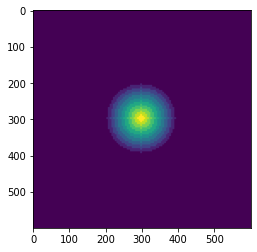

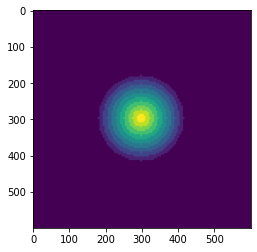

In [78]:
img1 = Image.open('images/1.png').convert('L')
img2 = Image.open('images/2.png').convert('L')
plt.imshow(img1)
plt.show()
plt.imshow(img2)

On remarque ici un cercle blanc lumineux qui se déforme en grossisant d'une frame à l'autre. La technique d'estimation du mouvement par Node-Base va nous permettre de rendre compte de cette déformation.

In [80]:
frame_array_1 = np.asarray(img1)
frame_array_2 = np.asarray(img2)
# Vérification 
assert frame_array_1.shape == frame_array_2.shape


On crée une classe `NodeBlock` pour manier facilement les blocs.

In [2]:
class NodeBlock:
    def __init__(self,coord: tuple) -> None:
        
        # Initialisation des vecteurs d_k
        self.d_k_vectors = np.zeros(shape=(4,2))
        
        # Coordonées du bloc ayant une forme supposée carrée.
        self.x_min = coord[0]
        self.x_max = coord[1]
        self.y_min = coord[2]
        self.y_max = coord[3]
        
        # Initialisation d'un tableau phi_k qui va contenir les coefficient des d_k
        self.phi_k = np.zeros(shape=(4))
    
    def get_phi_k(self, x:int, y:int):
        """
        Méthode qui récupère les phi_k au pixel de coordonnées x,y.
        """
        constant = (self.x_max - self.x_min)*(self.y_max - self.y_min)
        self.phi_k[0]=((self.x_max - x)*(self.y_max - y)/constant)
        self.phi_k[1]=((x - self.x_min)*(self.y_max - y)/constant)
        self.phi_k[2]=((x - self.x_min)*(y - self.y_min)/constant)
        self.phi_k[3]=((self.x_max - x)*(y - self.y_min)/constant)
        return self.phi_k
    
    def get_d_vector(self,x:int, y:int) -> tuple:
        """
        Génère le vecteur d en faisant la somme pondérée des phi_k et d_k.
        """
        phi_k = self.get_phi_k(x,y)
        x_d = np.sum(self.d_k_vectors[:,0] * phi_k)
        y_d = np.sum(self.d_k_vectors[:,1] * phi_k)
        return int(x_d),int(y_d)
    
    def get_vertices(self):
        """
        Récupération des coordonnées des sommets d'un bloc carré.
        """
        vertices = np.zeros(shape=(4,2))
        vertices[0] = ((self.x_min,self.y_min))
        vertices[1] = ((self.x_max,self.y_min))
        vertices[2] = ((self.x_max,self.y_max))
        vertices[3] = ((self.x_min,self.y_max))
        return vertices
    
    def get_d_vertices(self):
        """
        Récupération des coordonnées des sommets d'un bloc dans lequel on translate les coins d'un vecteur d_k.
        """
        return self.get_vertices() + self.d_k_vectors


In [85]:
class NodeBlockEstimator:
    def __init__(self,frame_array_1 :np.ndarray, frame_array_2 :np.ndarray, block_size: int = 10,learning_rate:float = 1e-6) -> None:
        self.frame_array_1 = frame_array_1
        self.frame_array_2 = frame_array_2
        self.learning_rate = learning_rate
        self.blocks_list = []
    
    def init_blocks(self,node_block_size = 100) -> None:
        """Initialise les blocs qui composent l'image.
        """
        for x in range(0,self.frame_array_1.shape[0],node_block_size):
            for y in range(0,self.frame_array_1.shape[1],node_block_size):
                new_block = NodeBlock((x,x+node_block_size-1,y,y+node_block_size-1))
                self.blocks_list.append(new_block)
    
    def psi_1(self,x:int,y:int) -> int:
        """
        Méthode qui détermine la luminescence de la frame 1.
        """
        if(x >= self.frame_array_1.shape[0] or y >= self.frame_array_1.shape[1]):
            return 0
        if(x < 0 or y < 0):
            return 0
        return np.sum(self.frame_array_1[x,y].astype(int))
    
    def psi_2(self,x:int,y:int) -> int:
        """
        Méthode qui détermine la luminescence de la frame 2.
        """
        if(x >= self.frame_array_2.shape[0] or y >= self.frame_array_2.shape[1]):
            return 0
        if(x < 0 or y < 0):
            return 0
        return np.sum(self.frame_array_2[x,y].astype(int))
    
    def plot_block(self,block: NodeBlock, ax: plt.Axes = None, fig: plt.Figure = None, color:str ='r') -> tuple:
        """"Affiche un bloc sur l'image"""
        vertices = block.get_d_vertices()
        quadrilateral = Polygon(vertices, closed=True, fill=None, edgecolor=color)
        if(ax is None or fig is None):
            fig, ax = plt.subplots(figsize=(10,10))
        # plt.imshow(self.frame_array_2)
        ax.imshow(self.frame_array_2)
        # Ajouter le quadrilatère aux axes
        ax.add_patch(quadrilateral)
        return fig,ax
        
    def get_EDFD(self,block: NodeBlock) -> int:
        """"Calcule l'erreur"""
        error = 0
        for x in range(block.x_min,block.x_max):
            for y in range(block.y_min,block.y_max):
                x_d,y_d = block.get_d_vector(x,y)
                diff = (np.sum( self.psi_2(x=x+x_d,y=y+y_d) - self.psi_1(x=x,y=y)))**2
                error +=diff
        return error
    
    def gradient_descent(self,block: NodeBlock, h:int=2) -> None:
        """
        Applique la descente de gradient sur une epoch
        """
        
        new_vectors = np.zeros(shape=(4,2))
        for i in range (block.d_k_vectors.shape[0]):
            for j in range(block.d_k_vectors.shape[1]):
                old_d_k = block.d_k_vectors[i,j]
                
                block.d_k_vectors[i,j]+= h
                EDFD_plus_h = self.get_EDFD(block)
                block.d_k_vectors[i,j]-= 2*h
                EDFD_minus_h = self.get_EDFD(block)
                derivate = (EDFD_plus_h - EDFD_minus_h)/(2*h)
                new_vectors[i,j] = int(old_d_k - self.learning_rate * derivate)
                
                block.d_k_vectors[i,j] = old_d_k
                 
                
        block.d_k_vectors = new_vectors
        
        

Affichage du découpage en bloc :

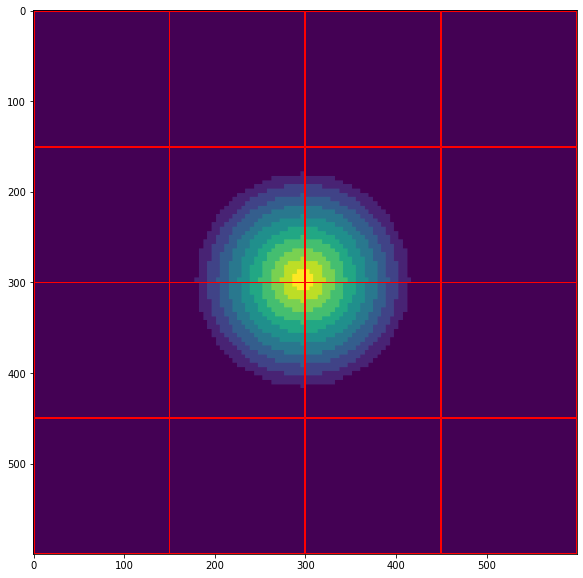

In [86]:
node_block_esimator = NodeBlockEstimator(frame_array_1=frame_array_1,frame_array_2=frame_array_2)
node_block_esimator.init_blocks(node_block_size = 150)
ax = None
fig =None
for block in node_block_esimator.blocks_list:
    fig,ax = node_block_esimator.plot_block(block=block, ax=ax,fig=fig)
plt.show()
fig.savefig(f'{OUTPUT_DIRECTORY}/initial_node.png')

Application du node-base sur une frame découpée en 16 blocs.

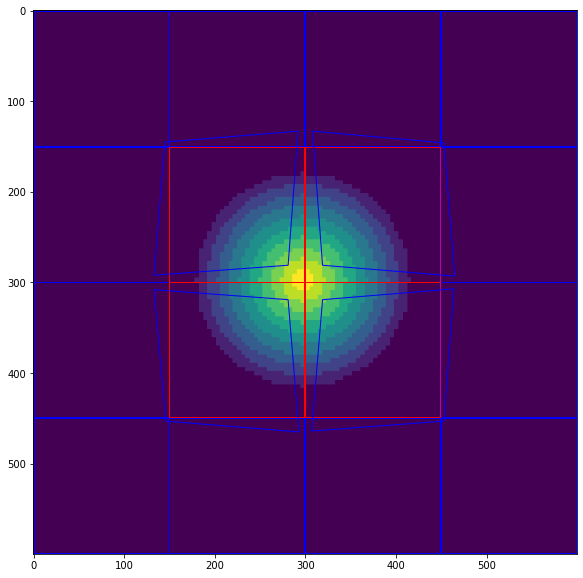

In [87]:
node_block_esimator = NodeBlockEstimator(frame_array_1=frame_array_1,frame_array_2=frame_array_2,learning_rate=5e-5)
node_block_esimator.init_blocks(node_block_size = 600//4)
fig,ax = None,None
for block in node_block_esimator.blocks_list:
    fig,ax = node_block_esimator.plot_block(block=block, ax=ax,fig=fig)
    node_block_esimator.gradient_descent(block,h=20)
    fig,ax = node_block_esimator.plot_block(block=block, ax=ax,color='b',fig=fig)

fig.savefig(f'{OUTPUT_DIRECTORY}/node_based_estimation.png')
plt.show()

Ici les traces bleues montrent l'évolution du mouvement d'une frame à l'autre. On remarque que les zones où il n'y a pas d'évolution de F1 à F2 restent carrées. Alors que celles au centre se déforment vers l'extérieur de la même manière que le cercle qui grossit d'une frame à l'autre.

### Mesh-Based

In [101]:
class MeshNode:
    def __init__(self,x:int, y:int) -> None:
        self.x = x 
        self.y = y
        self.d_vector = np.zeros(shape=(2))
    def __str__(self) -> str:
        return f'MeshNode at {self.x, self.y} with vector {self.d_vector}'


In [147]:
class MeshBlock:
    def __init__(self,x:int,y:int,size:int) -> None:
    
        # Coordonées du bloc ayant une forme supposée carrée.
        self.x = x 
        self.y = y
        self.size = size 
        # Initialisation d'un tableau phi_k qui va contenir les coefficient des d_k
        self.phi_k = np.zeros(shape=(4))
        # self.init_nodes()
        self.mesh_nodes = []
        for i in (0,1):
            for j in (0,1):
                self.mesh_nodes.append(MeshNode(x=x+i*self.size,y=y+j*self.size ))
        self.EDFD = -1
   
    
    def get_phi_k(self,x:int,y:int):
        x_max = self.x+self.size
        y_max = self.y+self.size
        constant = (x_max - self.x)*(y_max - self.y)
        self.phi_k[0]=((x_max - x)*(y_max - y)/constant)
        self.phi_k[1]=((x - self.x)*(y_max - y)/constant)
        self.phi_k[2]=((x - self.x)*(y - self.y)/constant)
        self.phi_k[3]=((x_max - x)*(y - self.y)/constant)
        return self.phi_k
    
    def get_d_vector(self,x:int, y:int) -> tuple:
        """
        Génère le vecteur d en faisant la somme pondérée des phi_k et d_k.
        """
        self.get_phi_k(x,y)
        x_d,y_d =0,0
        for i in range(4):
            x_d+= self.mesh_nodes[i].d_vector[0] * self.phi_k[i]
            y_d+= self.mesh_nodes[i].d_vector[1] * self.phi_k[i]
        return int(x_d),int(y_d)
    
    def __str__(self) -> str:
        return f'{[(str(node)) for node in self.nodes]}'





In [162]:
class MeshBasedEstimator:
    def __init__(self,frame_array_1 :np.ndarray, frame_array_2 :np.ndarray, block_size: int = 10,learning_rate:float = 1e-6) -> None:
        assert frame_array_1.shape == frame_array_2.shape
        self.frame_array_1 = frame_array_1
        self.frame_array_2 = frame_array_2
        self.learning_rate = learning_rate
        self.block_size = block_size
        self.init_blocks()
        
    def init_blocks(self):
        height,width = self.frame_array_1.shape[0:2]
        rows = height//self.block_size
        cols = width//self.block_size
        self.blocks_array = np.ndarray(shape=(rows,cols),dtype=MeshBlock)
        self.node_array = np.ndarray(shape=(rows+1,cols+1,2))
        for i in range(self.blocks_array.shape[0]):
            for j in range(self.blocks_array.shape[1]):
                x,y =self.block_size*i,self.block_size*j
                current_block = MeshBlock(x,y,self.block_size)
                self.blocks_array[i,j] = current_block
                for k in (0,1):
                    for l in (0,1):
                        self.node_array[i+k,j+l] = np.zeros(shape=(2))
                
     
    def psi_1(self,x:int,y:int) -> int:
        """
        Méthode qui détermine la luminescence de la frame 1.
        """
        if(x >= self.frame_array_1.shape[0] or y >= self.frame_array_1.shape[1]):
            return 0
        if(x < 0 or y < 0):
            return 0
        return np.sum(self.frame_array_1[x,y].astype(int))
    
    def psi_2(self,x:int,y:int) -> int:
        """
        Méthode qui détermine la luminescence de la frame 2.
        """
        if(x >= self.frame_array_2.shape[0] or y >= self.frame_array_2.shape[1]):
            return 0
        if(x < 0 or y < 0):
            return 0
        return np.sum(self.frame_array_2[x,y].astype(int))
    
    def get_EDFD(self,i:int,j:int) -> int:
        """"Calcule l'erreur"""
        error = 0
        block = self.blocks_array[i,j]
        for x in range(block.x,block.x+block.size):
            for y in range(block.y,block.y+block.size):
                vectors = self.node_array[i:i+2,j:j+2].reshape((4,2))
                phi_k = block.get_phi_k(x,y)
                x_d = int(np.sum(vectors[:,0] * phi_k))
                y_d = int(np.sum(vectors[:,1] * phi_k))
                diff = (np.sum( self.psi_2(x=x+x_d,y=y+y_d) - self.psi_1(x=x,y=y)))**2
                error +=diff
            break
        block.EDFD = error
        return error
               
    def dump_all(self):
        for element in self.node_array.flatten():
            print(element)
    
    def __str__(self) -> str:
        return f'MeshBased estimator with {self.blocks_array}'

mbe = MeshBasedEstimator(frame_array_1=frame_array_1,frame_array_2=frame_array_2,block_size=100)

mbe.get_EDFD(0,0)

0